### Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
- Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [37]:
from statsmodels.stats.power import TTestIndPower
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [53]:

data = pd.read_excel('AB_Test_Results.xlsx',sheet_name='AB Test Results')
data.head(10)

c:\УЧЕБА\.folder\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [39]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Проверяем отсутствие пустых значений

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [41]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Кол-во юзеров в выборках

In [42]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Посчитаем, кол-во типов по каждому пользователю.

In [43]:
v = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
v.head(20)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


Избавляемся от некорректных данных

In [44]:
df = data[~data.USER_ID.isin(v.query('VARIANT_NAME > 1').USER_ID)].sort_values('USER_ID')
df.shape[0], data.shape[0]

(6070, 10000)

Разделим выборки

In [45]:
control = df.query('VARIANT_NAME == "control"')
test = df.query('VARIANT_NAME == "variant"')

len(control),len(test)

(3026, 3044)

Тест на нормальность


In [46]:
alpha = 0.05

st = stats.shapiro(df.REVENUE)
print('Распределение  {} нормальное\n'.format({True:'не', False:''}[st[1] < alpha]))

Распределение  не нормальное



c:\УЧЕБА\.folder\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


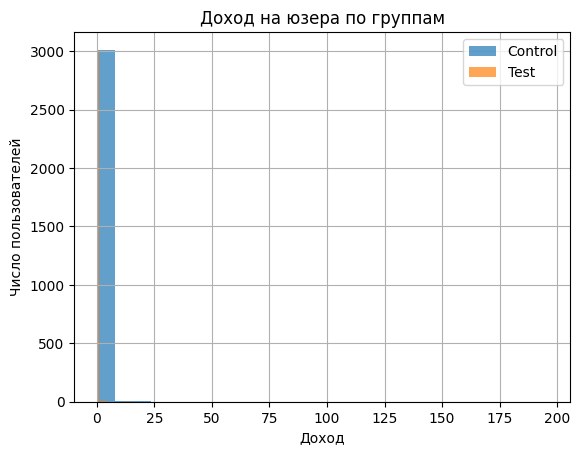

In [47]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

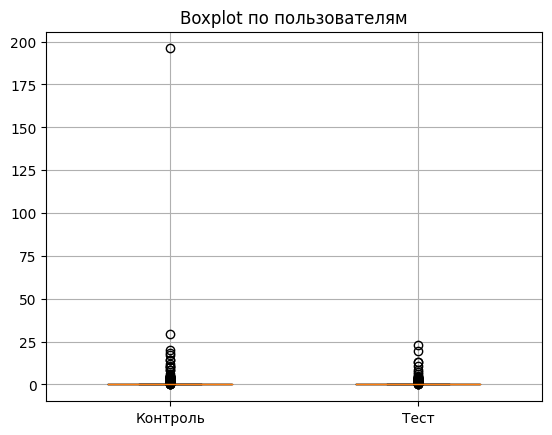

In [48]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis='both')

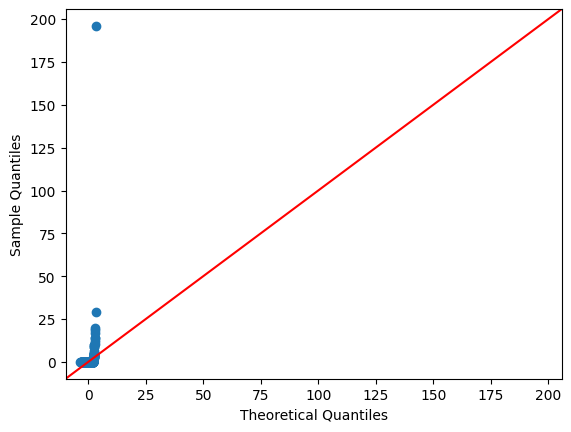

In [49]:
import statsmodels.api as sm
fig = sm.qqplot(control.REVENUE.values, line='45')
plt.show()

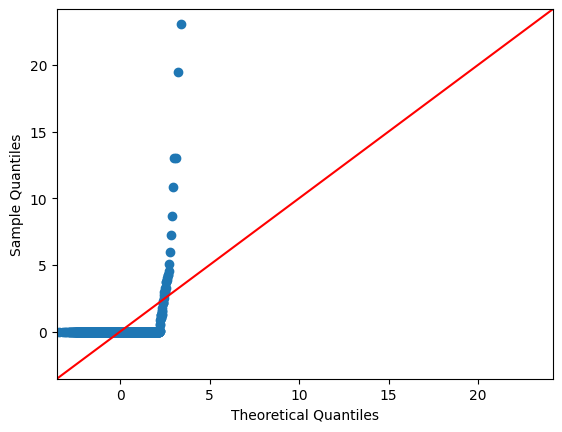

In [50]:
fig = sm.qqplot(test.REVENUE.values, line='45')
plt.show()

In [51]:
ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

 pvalue=0.1604844017690842  больше alpha = 0.05 - статистически значимых различий нет. <br>
Все методы показывают, что рапределение в выборках не является нормальным

In [54]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()
C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()
n =  len(control.REVENUE.values)
S = np.sqrt((T_std**2 + C_std **2)/ 2)
effect = float((T_mean-C_mean)/ S) 
alpha = 0.05

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,nobs1=n, ratio=1.0, alpha=alpha)
result

0.2893670730459213

Вывод
- довольно слабый тест по "мощности", нужно проработать оптимальную выборку.
- некоторые пользователи попали в обе выборки, нужно проверить работу А/В тестирования на корректность данных. 
- на основе проведенного тестирования мы видим что результат не удовлетворительный,<br>
не принимаем версию "В"(вторую версию) 